In [93]:
import numpy as np

import jax
from jax import jit
import jax.numpy as jnp
from jax import grad, random, vmap
from jax.lax.linalg import triangular_solve
import optax

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils import *
from kernels import * 

import wandb

from sklearn.decomposition import TruncatedSVD

In [94]:
num_trajectories = 20
time_steps = 40

time = jnp.linspace(0, 4 *jnp.pi, time_steps)[:, jnp.newaxis]
radii = jnp.linspace(0.1, 2, num_trajectories)
phases = jnp.linspace(0, 2*jnp.pi, num_trajectories)

X = time + phases 
sine_waves = jnp.sin(X) * radii
cosine_waves = jnp.cos(X) * radii
X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)   #K=50, N=2, T=200
K, N, T = X.shape

A = jnp.swapaxes(X, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

key = random.PRNGKey(41)
c = 50
indices = jax.random.choice(key, A.shape[1], shape=(c,), replace=False)
u = A[:, indices]                         #(N, c)

In [114]:
K_A_u =  K_X_Y_squared_exponential(A, u)               #(K*T, c)
K_u_u =  K_X_Y_squared_exponential(u, u)               #(c, c)
K_A_A = K_A_u @ K_u_u @ K_A_u.T
L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
jnp.allclose(K_u_u, L @ L.T)

alpha_tilde = random.normal(key, (K*T, 3))
Q, R = jnp.linalg.qr(K_A_u, mode='complete') 
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
#L_alpha = jnp.dot(L, alpha_tilde_QR)
#plt.imshow(triangular_solve(R.T, L, lower=True))

In [74]:
# K_A_A = K_X_Y_squared_exponential(A, A)
# K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
# means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
# K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
# Q, R = jnp.linalg.qr(K_A_A) 

# alpha_tilde = random.normal(key, (K*T, 3))
# alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
# alpha = Q @ jnp.linalg.inv(R.T) @ alpha_tilde_QR                 #Q @ triangular_solve(R.T, alpha_tilde_QR, lower=True)

(800, 3)

In [102]:
K_A_A = K_X_Y_squared_exponential(A, A)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, _ = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)
num_components = 10
P = P[:, :num_components]
S = S[:num_components]

In [104]:
def get_alpha(alpha_tilde, A, kernel_function, params):
    l_tilde = params['l_tilde']  
    sigma_f_tilde = params['sigma_f_tilde'] 
    l = jnp.exp(l_tilde)
    sigma_f = jnp.exp(sigma_f_tilde)

    #SVD
    K_A_A = kernel_function(A, A, l=l, sigma_f=sigma_f)
    K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
    means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
    K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
    P, S, _ = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)
    # num_components = 10
    # P = P[:, :num_components]
    # S = S[:num_components]
    
    alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    alpha = (P / jnp.sqrt(S+1e-1)) @ alpha_tilde_QR

    #Inducing points
    # K_A_u =  kernel_function(A, u, l=l, sigma_f=sigma_f)               #(K*T, c)
    # K_u_u =  kernel_function(u, u, l=l, sigma_f=sigma_f)               #(c, c)
    # K_A_A = jnp.einsum('kc,cj,mj ->km',  K_A_u, K_u_u, K_A_u)          #K_A_u @ K_u_u @ K_A_u.T (K*T, K*T)
    # L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-6)
    # Q, R = jnp.linalg.qr(K_A_u)                                        #(mode reduced Q(kt, c) R(c,c) versus complete Q (kt,kt) and R(KT, c))
    # alpha_tilde_QR = jnp.linalg.qr(alpha_tilde) 
    # alpha = Q @ triangular_solve(R.T, jnp.dot(L, alpha_tilde_QR), lower=True)

    #QR
    # K_A_A = kernel_function(A, A, l=l, sigma_f=sigma_f)
    # K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
    # means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
    # K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
    # Q, R = jnp.linalg.qr(K_A_A_tilde)                                #Q and R are (K*T, K*T)
    # alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    # #alpha = Q @ jnp.linalg.inv(R.T) @ alpha_tilde_QR                 #Q @ triangular_solve(R.T, alpha_tilde_QR, lower=True)
    # R_inv_transpose = triangular_solve(R.T, jnp.eye(R.shape[0]), lower=True)
    # alpha = Q @ R_inv_transpose @ alpha_tilde_QR
    return alpha

def single_pair_loss(alpha_H, A, params, kernel_function, id_1, id_2, operator = 'minus'):

    l_tilde = params['l_tilde']  
    sigma_f_tilde = params['sigma_f_tilde'] 
    l = jnp.exp(l_tilde)
    sigma_f = jnp.exp(sigma_f_tilde)

    K_A_X_i = kernel_function(A, X[id_1], l=l, sigma_f=sigma_f)                #K_A_X[:,id_1,:]
    K_X_A_i = kernel_function(A, X[id_2], l=l, sigma_f=sigma_f).T              #K_A_X[:,id_2,:].T
                  
    Q = jnp.einsum('kd,kt,tj,jm->dm', alpha_H, K_A_X_i, K_X_A_i, alpha_H)    #(KT,D).T @ (KT,T) and (T,KT) @ (KT,D) --> (D,T) @ (T,D) --> (D,D)
    QQ_product = Q @ Q                                                       # jnp.einsum('ij,jm->im', Q, Q)

    if operator == 'minus':
        return jnp.trace(Q)**2 - jnp.trace(QQ_product)
    
    elif operator == 'plus':
        return jnp.trace(Q)**2 + jnp.trace(QQ_product)
 

def loss(params, X, A, d,kernel_function, key, normalized = False):  
    K, N, T = X.shape

    alpha_tilde = params['alpha_tilde']
   
    alpha = get_alpha(alpha_tilde, A, kernel_function, params)

    alpha_reshaped = alpha.reshape(K,T,d)                           #(K, T, D)
    mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)        #(1, T, D)
    alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                #(K*T,D)

    num_pairs = 100  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=K) 
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, None, None, 0, 0))(alpha_H, A, params, kernel_function, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    if normalized == False:
        S = (2 / (num_pairs**2) ) * jnp.sum(batched_loss)
        return -S 
    else: 
        batched_normalizer = vmap(single_pair_loss, in_axes=(None, None, None, None, 0, 0, None))(alpha_H, A, params, kernel_function, index_pairs[:, 0], index_pairs[:, 1], 'plus')
        return jnp.sum(batched_loss) / jnp.sum(batched_normalizer)

def update(params, X, A, d, kernel_function, optimizer, opt_state, key):
    grad_loss = grad(loss)(params,X, A, d, kernel_function, key)
  
    updates, opt_state_updated = optimizer.update(grad_loss, opt_state, params)
    params_updated = optax.apply_updates(params, updates)
    return params_updated, opt_state_updated

def optimize(X, A, kernel_function=K_X_Y_squared_exponential, iterations=10000, learning_rate=0.001, d=3, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    
    alpha_tilde = random.normal(key, (K*T, d))
    l_tilde, sigma_f_tilde = random.normal(key, (2,))

    params = {
        'alpha_tilde': alpha_tilde,
        'l_tilde': l_tilde, 
        'sigma_f_tilde': sigma_f_tilde  
    }
    
    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    ls_loss = []
    ls_S_ratio = []
    
    for i in range(iterations):
        params, opt_state = update(params, X, A, d, kernel_function, optimizer, opt_state, keys[i])        

        loss_ = loss(params, X,A, d, kernel_function,keys[i])
        S_ratio = loss(params, X, A, d, kernel_function, keys[i], normalized = True)

        #wandb.log({"loss_": loss_, "S_ratio": S_ratio})

        ls_loss.append(loss_)
        ls_S_ratio.append(S_ratio)
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss_}, S_ratio: {S_ratio}")

    return params, ls_loss, ls_S_ratio

In [105]:
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=100, learning_rate=0.1, d=2)

Iteration 0, S: nan, S_ratio: nan
Iteration 10, S: nan, S_ratio: nan
Iteration 20, S: nan, S_ratio: nan
Iteration 30, S: nan, S_ratio: nan
Iteration 40, S: nan, S_ratio: nan
Iteration 50, S: nan, S_ratio: nan
Iteration 60, S: nan, S_ratio: nan
Iteration 70, S: nan, S_ratio: nan
Iteration 80, S: nan, S_ratio: nan
Iteration 90, S: nan, S_ratio: nan


0.096932076


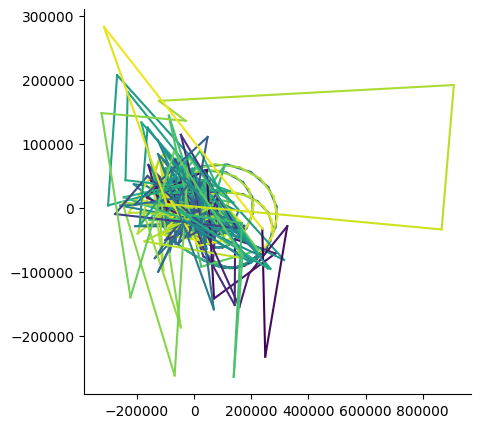

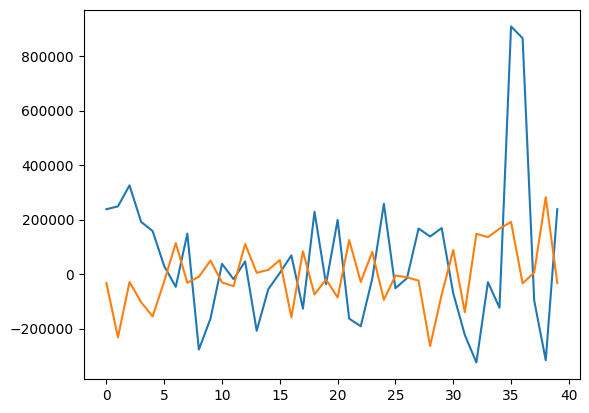

In [91]:
alpha_tilde = params['alpha_tilde']
l = jnp.exp(params['l_tilde'])
sigma_f = jnp.exp(params['sigma_f_tilde'])

d = 2
alpha = get_alpha(alpha_tilde, A,  kernel_function=K_X_Y_squared_exponential, params=params)

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)

K_A_X = np.zeros((K*T, K, T))
for k in range(K):
    K_A_X[:,k,:] = K_X_Y_squared_exponential(A, X[k], l = l, sigma_f=sigma_f)
K_A_X = jnp.array(K_A_X)

projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_2D(projection[:,:,:])
print(compute_S_all_pairs(projection))

plt.figure()
plt.plot(projection[-1,0,:])
plt.plot(projection[-1,1,:])

In [92]:
print(l)
print(sigma_f)

0.11419748
1.7590958
